# ML-модель предсказания судьбы стартапов.

Соревнование представляет собой увлекательный и практически важный опыт, ориентированный на студентов курса Data Science. Участникам предстоит работать с псевдо-реальными (реальные данные в которые добавлена синтетическая составляющая) данными о стартапах, функционировавших в период с 1970 по 2018 годы, и предсказать, какие из них закроются. Соревнование проводится на популярной платформе Kaggle, что позволяет участникам не только применять на практике свои знания в области анализа данных и машинного обучения, но и освоить работу с этой платформой.

# План моей работы:

1. Загрузка и ознакомление с данными
2. Предварительная обработка
3. Полноценный разведочный анализ
4. Разработка новых синтетических признаков
5. Проверка на мультиколлинеарность
6. Отбор финального набора обучающих признаков
7. Выбор и обучение моделей
8. Итоговая оценка качества предсказания лучшей модели
9. Анализ важности её признаков
10. Подготовка отчёта по исследованию.

In [1]:
!pip install phik -q

In [2]:
!pip install shap -q

In [3]:
!pip install catboost -q

In [4]:
from sklearn import tree
from sklearn.tree import plot_tree
import warnings 
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns
import phik
import shap
import os
from datetime import datetime, timedelta
from collections import Counter

from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler
)

from sklearn.metrics import (
    f1_score, 
    roc_auc_score, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report)

RANDOM_STATE = 42

## 1 Загрузка данных

In [5]:
startups_sample_submit = pd.read_csv(os.path.join('Desktop', 'мастерская', 'kaggle_startups_sample_submit_28062024.csv'))
startups_test = pd.read_csv(os.path.join('Desktop', 'мастерская', 'kaggle_startups_test_28062024.csv'))
startups_train = pd.read_csv(os.path.join('Desktop', 'мастерская', 'kaggle_startups_train_28062024.csv'))
    
pd.set_option('display.float_format', '{:,.2f}'.format)

In [6]:
startups_sample_submit.head()

,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,closed
4,DNA13,operating


In [7]:
startups_test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,"2,819,200.00",NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,"428,257.00",LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,"34,700,000.00",USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,"4,530,000.00",CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


In [8]:
startups_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,"828,626.00",operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,"42,935,019.00",operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,"35,456,381.00",operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,"22,250,000.00",operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


Все файлы соответствуют стандартам оформления данных

In [9]:
startups_sample_submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB


С типами данных в startups_sample_submit всё в порядке

In [10]:
startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [11]:
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [12]:
def date_year (date):
    date = date
    return int(date[0:4])

In [13]:
startups_train['founded_at'] = pd.to_datetime(startups_train['founded_at'], format='%Y-%m-%d')
startups_train['closed_at'] = pd.to_datetime(startups_train['closed_at'], format='%Y-%m-%d')
startups_train['first_funding_at'] = startups_train['first_funding_at'].apply(date_year)
startups_train['last_funding_at'] = startups_train['last_funding_at'].apply(date_year)
startups_test['first_funding_at'] = startups_test['first_funding_at'].apply(date_year)
startups_test['last_funding_at'] = startups_test['last_funding_at'].apply(date_year)

In [14]:
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  int64         
 11  last_funding_at    52516 non-null  int64         
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(3), object(7)
memory 

## 2 Предобработка данных

Проверю наличие пропущенных значений и дубликатов в датафреймах

In [15]:
startups_train.isna().sum()

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

Посчитаю долю

In [16]:
startups_train.isnull().mean() * 100

name                 0.00
category_list        4.69
funding_total_usd   19.17
status               0.00
country_code        10.48
state_code          12.88
region              12.11
city                12.11
funding_rounds       0.00
founded_at           0.00
first_funding_at     0.00
last_funding_at      0.00
closed_at           90.64
dtype: float64

**Описание пропущенных значений:**

**name** 1

**category_list** 2465 (4,69% от всех данных)

**funding_total_usd** 10069 (19,17% от всех данных)

**country_code** 5502 (10,48% от всех данных)

**state_code** 6763 (12,88% от всех данных)

**region** 6359 (12,11% от всех данных)

**city** 6359 (12,11% от всех данных)

**closed_at** 47599 (90,64% от всех данных)

In [17]:
rows_with_missing_values = startups_train[startups_train.isnull().any(axis=1)]
rows_with_missing_values

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,"828,626.00",operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011,2014,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,"42,935,019.00",operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010,2014,NaT
2,Reviva Pharmaceuticals,Biotechnology,"35,456,381.00",operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012,2014,NaT
3,Sancilio and Company,Health Care,"22,250,000.00",operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011,2014,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012,2012,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,NaN,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014,2014,NaT
52512,Hello Curry,Hospitality,"500,000.00",operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014,2014,NaT
52513,Taskforce,Email|Messaging|Productivity Software,"50,000.00",operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009,2011,NaT
52514,NetScaler,Security,"13,000,000.00",operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998,2004,NaT


In [18]:
startups_test.isna().sum()

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

In [19]:
startups_test.isnull().mean() * 100

name                 0.00
category_list        4.50
funding_total_usd   19.64
country_code        10.53
state_code          12.91
region              12.11
city                12.09
funding_rounds       0.00
first_funding_at     0.00
last_funding_at      0.00
lifetime             0.00
dtype: float64

**Описание пропущенных значений:**

**category_list** 591 (4,5% от всех данных)

**funding_total_usd** 2578 (19,64% от всех данных)

**country_code** 1382 (10,53% от всех данных)

**state_code** 1695 (12,91% от всех данных)

**region** 1589 (12,11% от всех данных)

**city** 1587 (12,09% от всех данных)

In [20]:
rows_with_missing_values = startups_test[startups_test.isnull().any(axis=1)]
rows_with_missing_values

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,"2,819,200.00",NIC,17,NaN,NaN,1,2009,2009,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010,2010,2717
5,Quickfire Games,Design|Entertainment|Games,"160,000.00",NaN,NaN,NaN,NaN,2,2013,2014,1583
7,Triosyn,Health Care|Medical|Therapeutics,"4,000,000.00",NaN,NaN,NaN,NaN,1,2003,2003,5576
10,Omega Discovery Solutions,Consulting|Enterprises,NaN,USA,AZ,Phoenix,Phoenix,1,2014,2014,1660
...,...,...,...,...,...,...,...,...,...,...,...
13111,Beijing 1000CHI Software Technology,Mobile,"43,923,865.00",NaN,NaN,NaN,NaN,1,2010,2010,3653
13113,The Fabulous,Apps,NaN,FRA,A8,Paris,Paris,1,2015,2015,1273
13114,VIPTALON,Discounts|Fashion|Shopping,NaN,RUS,48,Moscow,Moscow,1,2011,2011,2545
13115,Vizionware,NaN,"8,199,999.00",USA,TX,Austin,Austin,1,2007,2007,4365


In [21]:
startups_sample_submit.isna().sum()

name      0
status    0
dtype: int64

Проверю дубликаты в данных

In [22]:
startups_train.duplicated().sum()

0

In [23]:
startups_test.duplicated().sum()

0

In [24]:
startups_sample_submit.duplicated().sum()

0

Явные дубликаты отсутствуют

In [25]:
dt = datetime(2018, 1, 1)
startups_train['closed_at'] = startups_train['closed_at'].fillna(dt)

# Name

In [26]:
startups_train['name'] = startups_train['name'].fillna('Qwertyu')

# Category_list

In [27]:
startups_train['category_list'] = startups_train['category_list'].fillna('unknown')
startups_test['category_list'] = startups_test['category_list'].fillna('unknown')

In [28]:
startups_train['category_list'].nunique()

22106

In [29]:
startups_train['category_list'] = startups_train['category_list'].str.lower()
startups_test['category_list'] = startups_test['category_list'].str.lower()

In [30]:
startups_train['category_list'].value_counts().head(20)

category_list
software               3207
biotechnology          2905
unknown                2465
e-commerce             1064
mobile                  920
clean technology        892
curated web             853
health care             744
hardware + software     733
games                   681
enterprise software     671
health and wellness     613
manufacturing           604
advertising             554
education               423
semiconductors          400
finance                 338
real estate             338
consulting              330
social media            326
Name: count, dtype: int64

In [31]:
startups_test['category_list'] = startups_test['category_list'].apply(lambda x: [x] if not isinstance(x, list) else x)
def category (category_list):
    category_mapping = {
        'biotech': ['biotech'],
        'messaging': ['messag'],
        'food processing': ['food', 'beer', 'restaurants', 'wine'],
        'clean technology': ['clean', 'recycling'],
        'education': ['educ', 'edtech'],
        'health care': ['health', 'medical', 'clinic', 'medic', 'pharm', 'hospital', 'dental', 'therap'],
        'e-commerce': ['e-commerce', 'marketplaces', 'social commerce'],
        'finance': ['finance', 'fin', 'bank', 'bitcoin', 'credit'],
        'mobile': ['mobile'],
        'software': ['software', 'saas', 'ios', 'android'],
        'hardware': ['hardware'],
        'games': ['game', 'gaming'],
        'analytics': ['analytic'],
        'design': ['design'],
        'media': ['news', 'media'],
        'music': ['music'],
        'web': ['web'],
        'hospitality': ['hospitality', 'hotels', 'beauty'],
        'travel': ['travel'],
        'fashion': ['fashion'],
        'transportation': ['transport'],
        'sports': ['sport'],
        'information technology': ['informat', 'digit', 'internet', 'computers', 'data', 'computer vision'],
        'photo and video': ['video', 'photo'],
        'oil & gas': ['oil', 'gas'],
        'technology': ['semiconductor', 'manufacturing', 'robot', 'automotive', 'nano', '3d'],
        'businesses': ['busines', 'b2b'],
        'security': ['security', 'safety'],
        'advertising': ['advertising'],
        'energy': ['energ', 'solar'],
        'unknown': ['unknown']
    }

    for category, keywords in category_mapping.items():
        if any(keyword in category_list for keyword in keywords):
            return category
    
    return category_list

In [32]:
print(startups_test['category_list'].head(20))

0                                    [clean technology]
1                                         [hospitality]
2                                             [finance]
3                      [software|video|video streaming]
4                                            [software]
5                          [design|entertainment|games]
6                                       [biotechnology]
7                    [health care|medical|therapeutics]
8                                            [software]
9                                            [software]
10                             [consulting|enterprises]
11                                             [mobile]
12                                    [big data|travel]
13    [call center automation|saas|telecommunication...
14                                   [edtech|education]
15         [advertising|video streaming|virtual worlds]
16    [advertising|mobile|mobile advertising|optimiz...
17                       [location based service

In [33]:
startups_train['category_list'] = startups_train['category_list'].apply(category)
startups_test['category_list'] = startups_test['category_list'].apply(category)

In [34]:
categories = startups_test['category_list'].value_counts().head(30).reset_index()
categories = list(categories['category_list'])

In [35]:
def other (row):
    if row in categories:
        return row
    else:
        return 'other'

In [36]:
startups_train['category_list'] = startups_train['category_list'].apply(other)
startups_test['category_list'] = startups_test['category_list'].apply(other)

In [37]:
startups_train['category_list'] = startups_train['category_list'].fillna('unknown')
startups_test['category_list'] = startups_test['category_list'].fillna('unknown')

In [38]:
startups_test['category_list'].value_counts().head(20)

category_list
other                    7743
software                  779
[biotechnology]           693
unknown                   591
e-commerce                279
mobile                    255
[clean technology]        234
[curated web]             191
[hardware + software]     181
[games]                   180
technology                179
[health care]             176
[enterprise software]     169
[health and wellness]     148
advertising               141
finance                   115
[education]               101
[semiconductors]           96
[consulting]               87
security                   87
Name: count, dtype: int64

In [39]:
startups_train.category_list.nunique()

14

Удалось сократить уникальные значения до 14

# Funding total usd

In [40]:
startups_train['funding_total_usd'].nunique()

15551

In [41]:
startups_train.funding_total_usd.min()

1.0

In [42]:
startups_train.funding_total_usd.max()

30079503000.0

In [43]:
startups_train.funding_total_usd.describe()

count           42,447.00
mean        18,247,480.66
std        187,117,301.32
min                  1.00
25%            336,027.50
50%          2,000,000.00
75%         10,000,000.00
max     30,079,503,000.00
Name: funding_total_usd, dtype: float64

Медианное значение составляет 2,2 млн., при этом среднее значение составляет 18,7 млн. Это означает, что присутствуют выбросы.

# Country code

In [44]:
startups_train.country_code.unique()

array(['CHE', 'USA', nan, 'GBR', 'RUS', 'ESP', 'FRA', 'SWE', 'IND', 'KOR',
       'AUS', 'TWN', 'CHN', 'HUN', 'CAN', 'FIN', 'BRA', 'EGY', 'PRT',
       'ISR', 'CHL', 'SVK', 'NLD', 'ARG', 'ARE', 'JPN', 'IRL', 'DEU',
       'LBN', 'EST', 'IDN', 'BEL', 'MEX', 'DNK', 'ITA', 'GRC', 'ROM',
       'TUR', 'SGP', 'SAU', 'MYS', 'NGA', 'QAT', 'VNM', 'BGR', 'GHA',
       'UGA', 'JOR', 'AUT', 'PAK', 'NZL', 'HKG', 'ZAF', 'LVA', 'NOR',
       'HRV', 'VEN', 'PER', 'LUX', 'SVN', 'POL', 'PHL', 'NIC', 'CZE',
       'ISL', 'PAN', 'URY', 'BGD', 'MCO', 'GTM', 'THA', 'TTO', 'UKR',
       'KEN', 'CRI', 'DZA', 'LTU', 'CYM', 'MUS', 'BLR', 'SLV', 'COL',
       'MLT', 'PSE', 'BLZ', 'CYP', 'MMR', 'MKD', 'KHM', 'GIB', 'SRB',
       'DOM', 'BWA', 'BLM', 'PRY', 'BMU', 'TAN', 'LIE', 'GRD', 'UZB',
       'GEO', 'SEN', 'ALB', 'ECU', 'MOZ', 'LKA', 'LAO', 'TUN', 'HND',
       'ZWE', 'BAH', 'MDA', 'MAF', 'BHR', 'AZE', 'MAR', 'KWT', 'IRN',
       'GGY', 'KNA', 'PRI', 'OMN', 'KAZ', 'JAM', 'NPL', 'ARM', 'TGO',
       'RWA', '

In [45]:
countries = startups_test['country_code'].value_counts().head(30).reset_index()
countries = list(countries['country_code'])

In [46]:
def other (row):
    if row in countries:
        return row
    else:
        return 'other'

In [47]:
startups_train['country_code'] = startups_train['country_code'].apply(other)
startups_test['country_code'] = startups_test['country_code'].apply(other)

In [48]:
startups_train['country_code'] = startups_train['country_code'].fillna('unknown')
startups_test['country_code'] = startups_test['country_code'].fillna('unknown')

In [49]:
startups_train.isna().sum()

name                     0
category_list            0
funding_total_usd    10069
status                   0
country_code             0
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at                0
dtype: int64

In [50]:
def filter_category(df_col, tresh):
  counts = Counter(df_col)
  filtered_categories = [category for category, count in counts.items() if count > tresh]
  return filtered_categories
def replace_N_col(code, valid_keys):
  return code if code in valid_keys else "Other"
def comb_country_state(country_code, state_code):
  return f"{country_code}_{state_code}" if country_code == "USA" else country_code

# STATE CODE

In [51]:
startups_train['state_code'] = startups_train['state_code'].fillna('Not_ident')
startups_test['state_code'] = startups_test['state_code'].fillna('Not_ident')  

# CITY

In [52]:
startups_train['city'] = startups_train['city'].fillna('Not_ident')
startups_test['city'] = startups_test['city'].fillna('Not_ident')

In [53]:
startups_train.loc[startups_train['city'].isna() == False, 'city'] = startups_train[startups_train['city'].isna() == False]['city'].str.split(' - Other').apply(lambda x: x[0])

In [54]:
print(f"До {len(startups_train['city'].unique())}")
key_state = filter_category(startups_train['city'], 30)
startups_train['city'] = startups_train['city'].apply(replace_N_col, valid_keys=key_state)
startups_test['city'] = startups_test['city'].apply(replace_N_col, valid_keys=key_state)
print(f"После {len(startups_train['city'].unique())}")

До 4478
После 218


# REGION

In [55]:
startups_train['region'] = startups_train['region'].fillna('Not_ident')
startups_test['region'] = startups_test['region'].fillna('Not_ident')

In [56]:
startups_train.loc[startups_train['region'].isna() == False, 'region'] = startups_train[startups_train['region'].isna() == False]['region'].str.split(' - Other').apply(lambda x: x[0])

In [57]:
print(f"До {len(startups_train['region'].unique())}")
key_state = filter_category(startups_train['region'], 30)
startups_train['region'] = startups_train['region'].apply(replace_N_col, valid_keys=key_state)
startups_test['region'] = startups_test['region'].apply(replace_N_col, valid_keys=key_state)
print(f"После {len(startups_train['region'].unique())}")

До 1037
После 188


# CLOSED AT

Пропущенный значения заполню датой выгрузки данных и базы (2018-01-01). Отсутствующие значения в пропуске могут говорить о том, что стартап на момент выгрузки продолжал работу. 

In [58]:
startups_train['closed_at'] = startups_train['closed_at'].fillna(pd.to_datetime('2018-01-01', format='%Y-%m-%d'))

# lifetime

In [59]:
startups_train['closed_at'] = pd.to_datetime(startups_train['closed_at'])
startups_train['founded_at'] = pd.to_datetime(startups_train['founded_at']) 

In [60]:
startups_train['lifetime'] = (startups_train['closed_at'] - startups_train['founded_at']).dt.days
startups_train[:3]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
0,Lunchgate,other,"828,626.00",operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011,2014,2018-01-01,2998
1,EarLens,health care,"42,935,019.00",operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010,2014,2018-01-01,4748
2,Reviva Pharmaceuticals,other,"35,456,381.00",operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012,2014,2018-01-01,4383


In [61]:
startups_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
0,Lunchgate,other,"828,626.00",operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011,2014,2018-01-01,2998
1,EarLens,health care,"42,935,019.00",operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010,2014,2018-01-01,4748
2,Reviva Pharmaceuticals,other,"35,456,381.00",operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012,2014,2018-01-01,4383
3,Sancilio and Company,health care,"22,250,000.00",operating,other,Not_ident,Not_ident,Not_ident,3,2004-01-01,2011,2014,2018-01-01,5114
4,WireTough Cylinders,technology,NaN,operating,USA,VA,Other,Bristol,1,2010-05-12,2012,2012,2018-01-01,2791


# Проверю временные данные

Закрытие стартапа до момента открытия 

In [62]:
(startups_train['first_funding_at'] > startups_train['last_funding_at']).sum()

0

In [63]:
(startups_train['founded_at'] > startups_train['closed_at']).sum()

0

**Вывод:**
- разобралась с дубликатами и пропусками
- заполнила пропуски, или оставила их и в дальнейшем заполню
- разобрала категории

# Исследовательский анализ данных

C:\Users\Public\anac\Lib\site-packages\pandas\plotting\_matplotlib\misc.py:121: RuntimeWarning: invalid value encountered in cast
  if np.all(locs == locs.astype(int)):


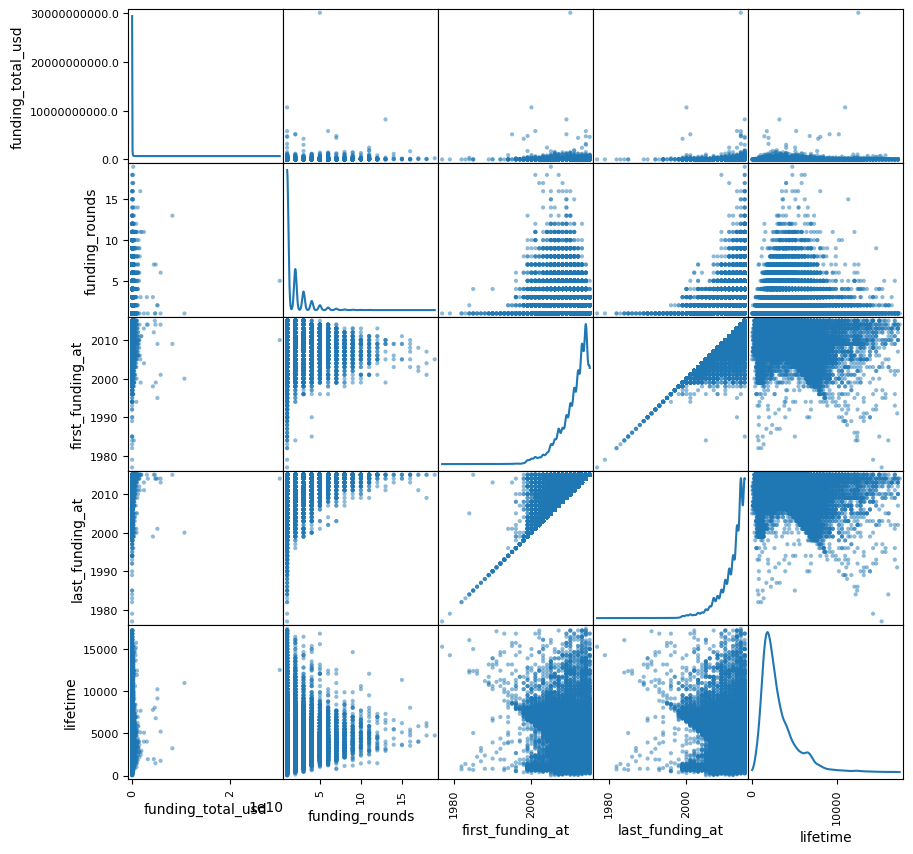

In [64]:
pd.plotting.scatter_matrix(startups_train, alpha=0.5, figsize=(10, 10), diagonal='kde')
plt.show()

In [65]:
startups_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
0,Lunchgate,other,"828,626.00",operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011,2014,2018-01-01,2998
1,EarLens,health care,"42,935,019.00",operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010,2014,2018-01-01,4748
2,Reviva Pharmaceuticals,other,"35,456,381.00",operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012,2014,2018-01-01,4383
3,Sancilio and Company,health care,"22,250,000.00",operating,other,Not_ident,Not_ident,Not_ident,3,2004-01-01,2011,2014,2018-01-01,5114
4,WireTough Cylinders,technology,NaN,operating,USA,VA,Other,Bristol,1,2010-05-12,2012,2012,2018-01-01,2791


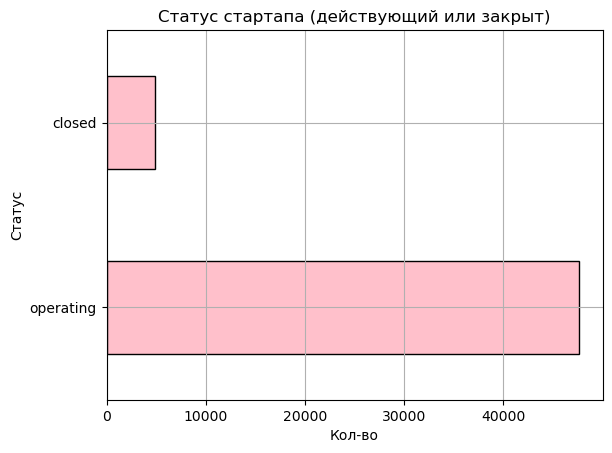

In [66]:
startups_train['status'].value_counts().plot(title = 'Статус стартапа (действующий или закрыт)', kind = 'barh', color='pink', edgecolor='black', grid=True)
plt.xlabel('Кол-во')
plt.ylabel('Статус')
plt.show()

Преобладает действующий статус стартапов

Создам фун-ию для топ-5 показателей

In [67]:
def cat(variable, name, table):
    counts = table[variable].value_counts().sort_values(ascending=False)
    plt.bar(counts.head(5).index, counts.head(5).values)
    plt.xlabel(name)
    plt.ylabel('Количество')
    plt.title(f'Признак: {name}')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(counts.min()*0.9, counts.max()*1.05)
    plt.show()

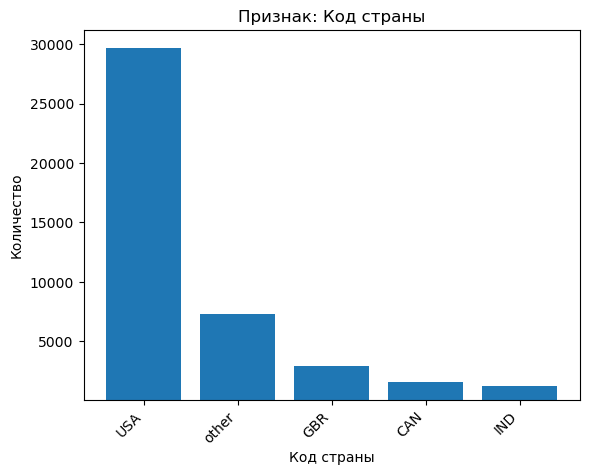

In [68]:
cat('country_code', 'Код страны', startups_train)

**В топ-5 среди кода страны входят:**
- USA
- Неиденфицированные
- GBR
- CAN
- IND

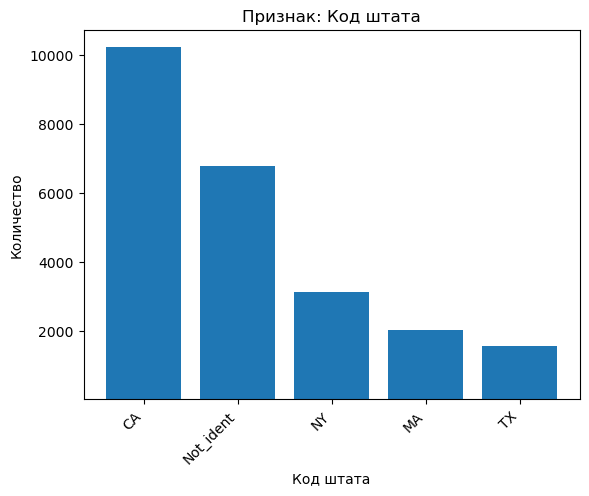

In [69]:
cat('state_code', 'Код штата', startups_train)

**Топ-5 среди кода штата:**
- CA
- Неидентифицирован
- NY
- MA
- TX

In [70]:
def e_d_a (variable, name, table):
    plt.figure(figsize=(15, 6))
    table[variable].hist(bins=30, range=(max(0, table[variable].min()), table[variable].max()))
    plt.title(f'Распределение: {name}')
    plt.xlabel(f'{name}')
    plt.ylabel('Частота')
    plt.show()
    
    plt.figure(figsize=(15, 4))
    table.boxplot(column=variable, color='green', widths=0.6)
    plt.title(f'Ящик с усами: {name}')
    plt.xlabel(f'{name}')
    plt.yticks([]) 
    plt.grid(True, linestyle='--', alpha=0.2, linewidth=1.5)
    plt.show()
    print('\n', f'{name} находится в диапазоне от {table[variable].min():.2f}',
          f'до {table[variable].max():.2f}'
         )

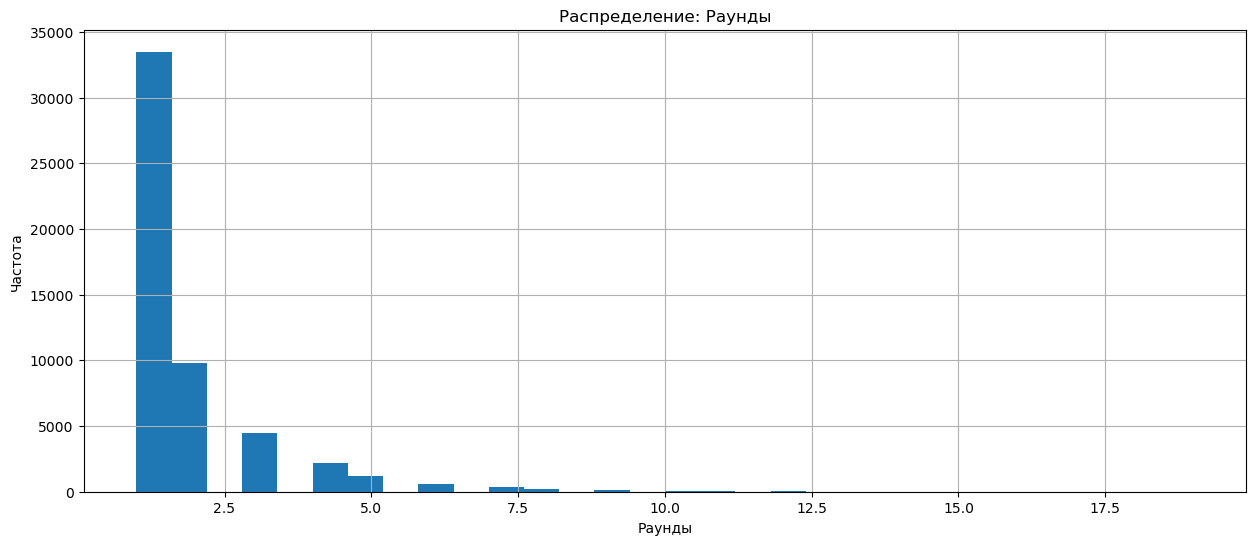

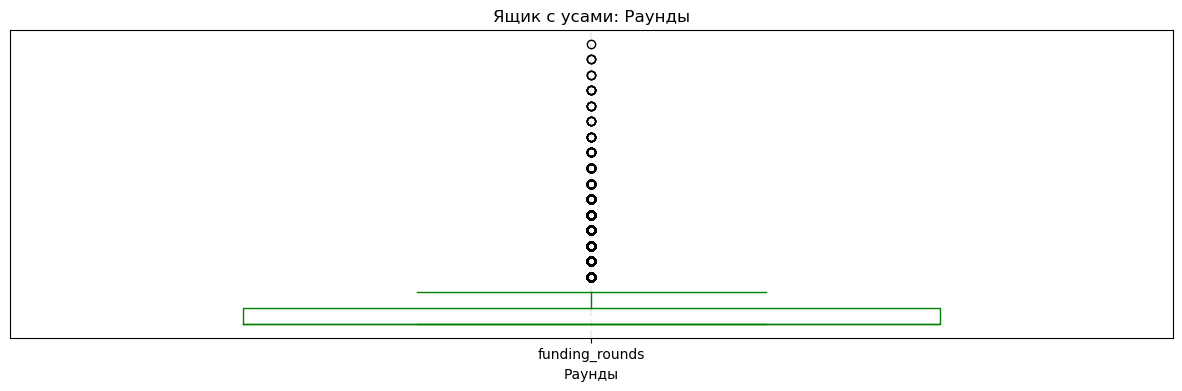


 Раунды находится в диапазоне от 1.00 до 19.00


In [71]:
e_d_a('funding_rounds', 'Раунды', startups_train)

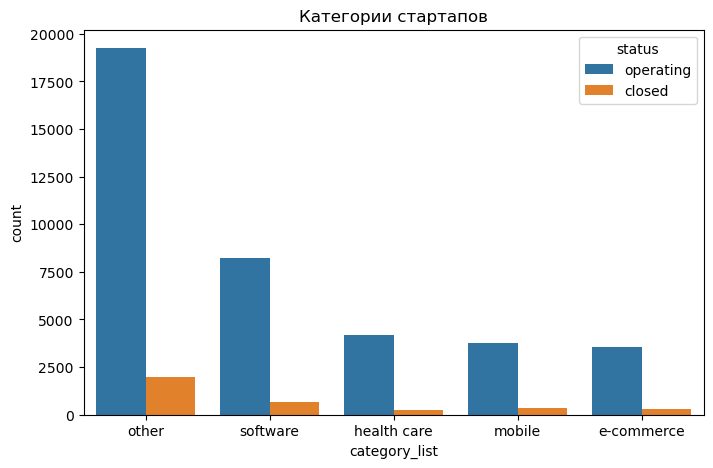

In [72]:
plt.figure(figsize=(8,5))
sns.countplot(data= startups_train, x='category_list', order=startups_train['category_list'].value_counts().head(5).index, hue="status")
plt.title('Категории стартапов')
plt.show()

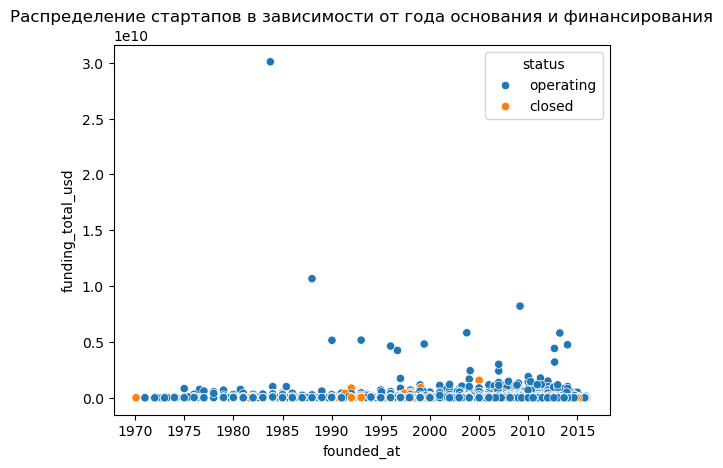

In [73]:
sns.scatterplot(data=startups_train, x='founded_at', y='funding_total_usd', hue='status')
plt.title('Распределение стартапов в зависимости от года основания и финансирования') 
plt.show()

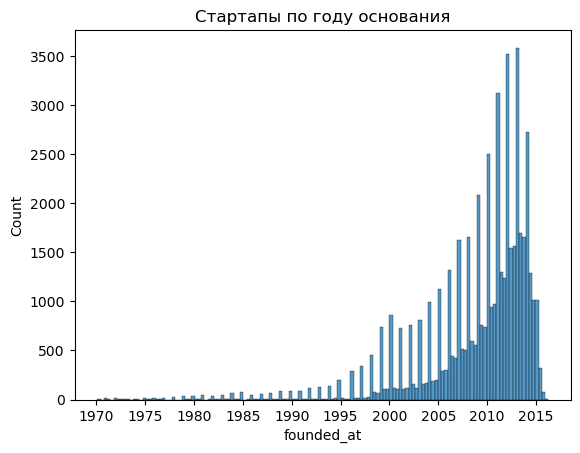

In [74]:
sns.histplot(startups_train['founded_at'])
plt.title('Стартапы по году основания')
plt.show()

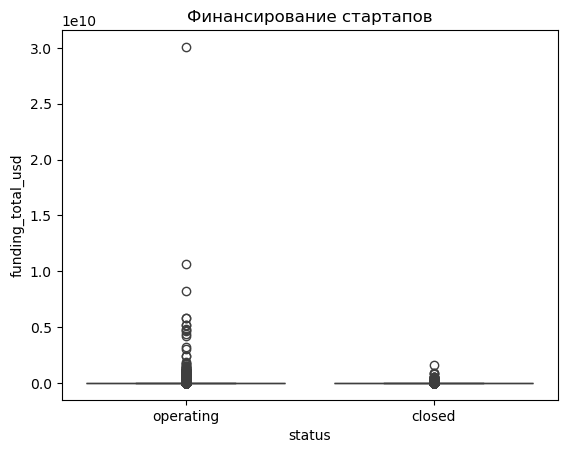

In [75]:
sns.boxplot(data=startups_train, y='funding_total_usd', x='status')
plt.title('Финансирование стартапов')
plt.show()

In [76]:
startups_train = startups_train[startups_train['funding_total_usd']<4000000]
startups_test = startups_test[startups_test['funding_total_usd']<4000000]

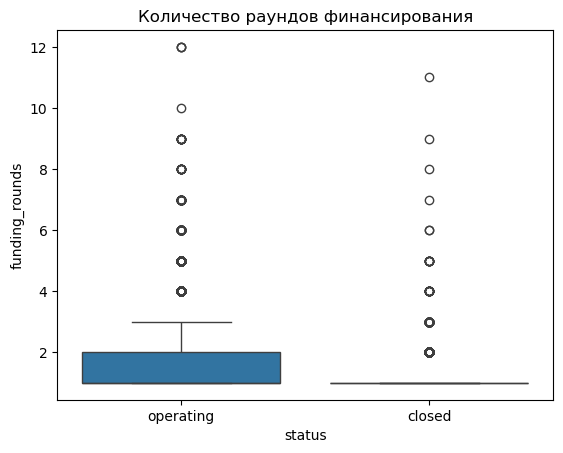

In [77]:
sns.boxplot(data=startups_train, y='funding_rounds', x='status')
plt.title('Количество раундов финансирования')
plt.show()

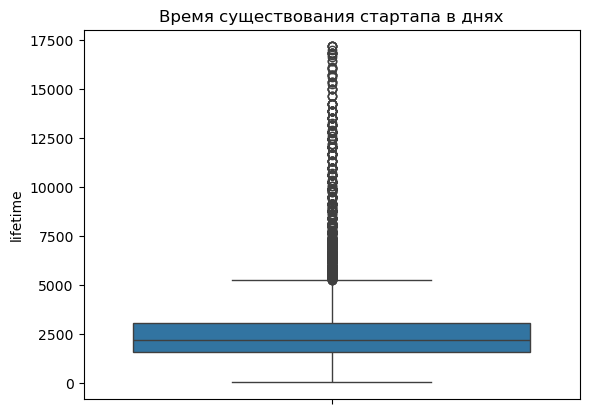

In [78]:
sns.boxplot(data=startups_train['lifetime'])
plt.title('Время существования стартапа в днях')
plt.show()

<Axes: title={'center': 'Соотношение категорий закрытых компаний'}, xlabel='category_list,status'>

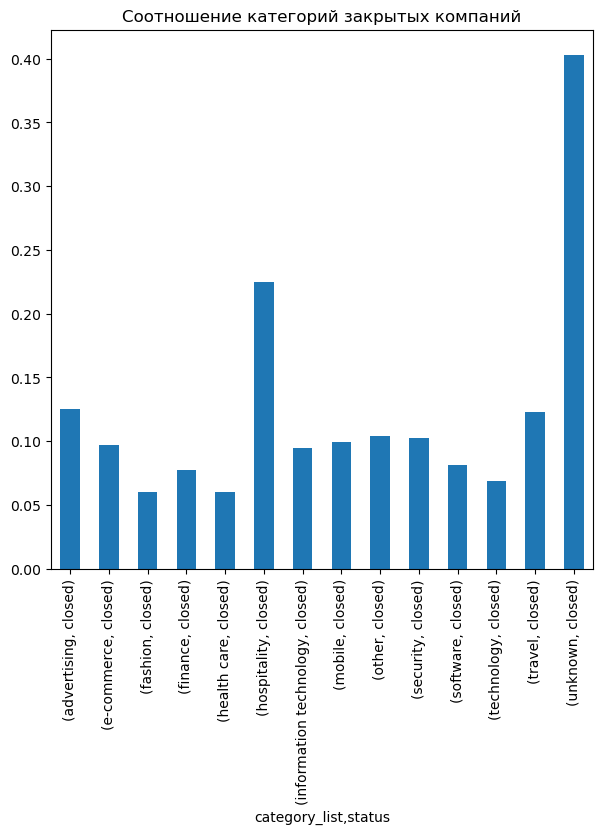

In [79]:
cat_stat = startups_train.groupby(['category_list'])['status'].value_counts(normalize=True)
cat_stat.loc[cat_stat.index.get_level_values(1) == 'closed'].plot(title="Соотношение категорий закрытых компаний",
                                                      kind='bar', figsize=(7, 7))

**Матрица корреляции**

interval columns not set, guessing: ['funding_total_usd', 'funding_rounds', 'first_funding_at', 'last_funding_at', 'lifetime']


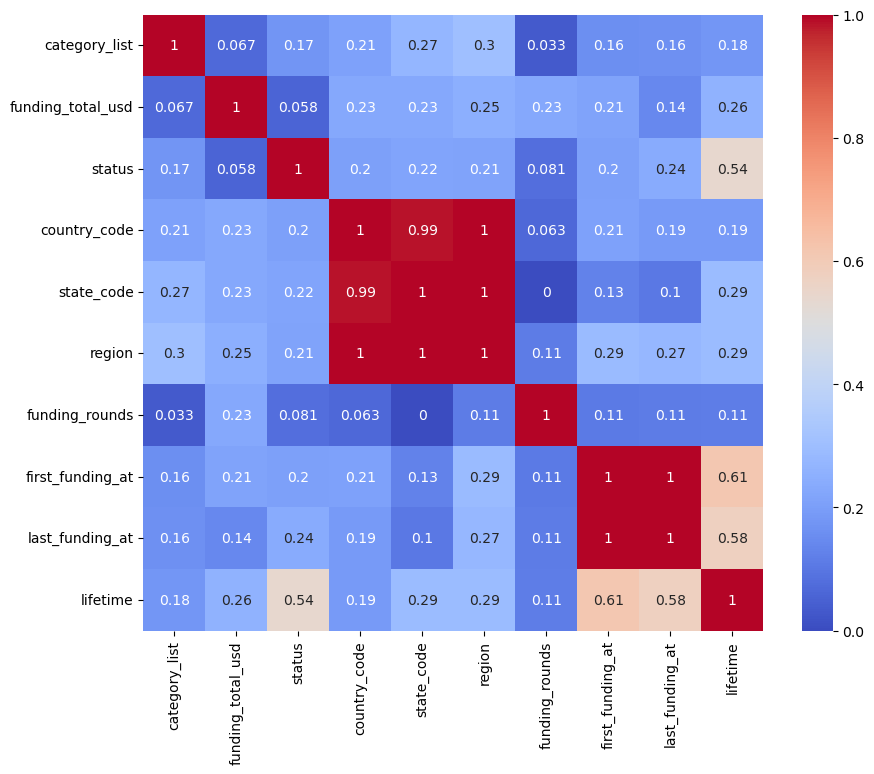

In [80]:
corr_matrix_phik = startups_train.drop(['name','city','closed_at','founded_at'], axis=1).phik_matrix()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_phik, annot=True, cmap='coolwarm')
plt.show()

**Вывод:**
- большая часть стартапов зарегистрирована в США.
- большинство стартапов имеют только одинраунд финансирования, это может означать высокий риск или же начальный этап развития большей части стартапов в выборке.
- около 90% стартапов не были закрыты на момент сборки данных, это позволяет сфокусироваться на анализе факторов, которые влияют на долгосрочную устойчивость.

**Мультиколлинеарность**

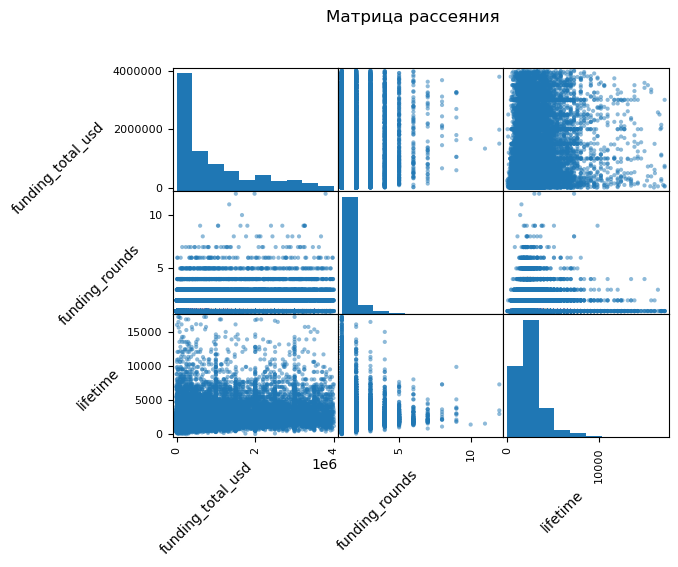

In [81]:
scatter_matrix = pd.plotting.scatter_matrix(startups_train[[
    'funding_total_usd', 'status', 'country_code',
    'state_code', 'region', 'funding_rounds',
    'lifetime']])

plt.suptitle('Матрица рассеяния', y=1)
for ax in scatter_matrix.ravel():
    ax.yaxis.label.set_rotation(45)
    ax.yaxis.label.set_ha('right')
    ax.xaxis.label.set_rotation(45)
    ax.xaxis.label.set_ha('right')

plt.show()

Коды регионов и штатов имеют мультиколлинеарность

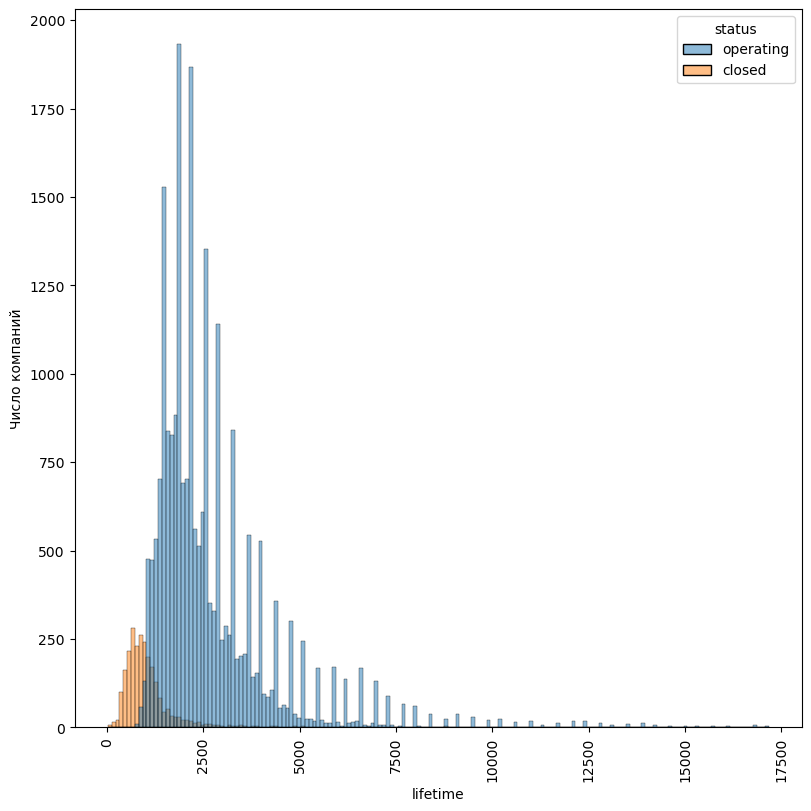

In [82]:
fig, axs = plt.subplots(constrained_layout = True, dpi = 100, figsize = (8, 8))
sns.histplot(data = startups_train[[
    'funding_total_usd', 'status', 'country_code',
    'state_code', 'region', 'funding_rounds',
    'lifetime']], x = 'lifetime', hue = 'status')
axs.set_ylabel('Число компаний')
plt.xticks(rotation = 90)
plt.show()

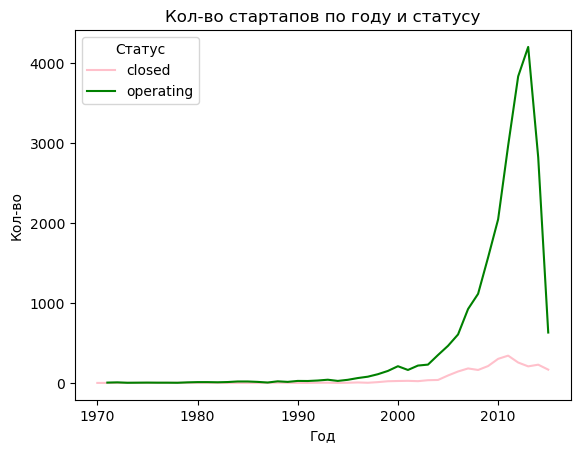

In [83]:
grouped_data_close = startups_train[startups_train['status'] == 'closed'].groupby(startups_train['founded_at'].dt.year).size()
grouped_data_open = startups_train[startups_train['status'] == 'operating'].groupby(startups_train['founded_at'].dt.year).size()

plt.plot(grouped_data_close.index, grouped_data_close.values, label='closed', color='pink')
plt.plot(grouped_data_open.index, grouped_data_open.values, label= 'operating', color='green')

plt.title('Кол-во стартапов по году и статусу')
plt.xlabel('Год')
plt.ylabel('Кол-во')
plt.legend(title='Статус', loc='upper left')
plt.show()

# Обучение модели

In [84]:
X = startups_train.drop(['name','city','closed_at','founded_at', 'status', 'state_code', 'region'], axis=1)
y = startups_train['status']

TEST_SIZE = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y
)

display((X_train.shape, y_train.shape), (X_test.shape, y_test.shape))

((20518, 7), (20518,))

((5130, 7), (5130,))

In [85]:
#ohe_columns = ['category_list','country_code']
#ord_columns = ['funding_rounds']
#num_columns = ['funding_total_usd','first_funding_at', 'last_funding_at','lifetime']

In [86]:
ohe_columns = X_train.select_dtypes(include=['category', 'object']).columns
num_columns = X_train.select_dtypes(include='number').columns

In [87]:
def scorer (y_train,y_pred):
    return f1_score(y_train,y_pred,pos_label='operating')
scorer_f1 = make_scorer(scorer, greater_is_better=True)

In [88]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
    ]
) 

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
    ]
) 

param_grid = [
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, silent=True)],
        'models__iterations': range(1, 30, 5),
        'models__depth': range(1, 20, 5),
        'models__l2_leaf_reg': range(1, 10, 2),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=scorer_f1,
    n_iter=10,
    random_state=RANDOM_STATE,    
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

display('Лучшая модель и её параметры:', randomized_search.best_estimator_)
display ('Метрика лучшей модели на кросс валидации:', randomized_search.best_score_)

'Лучшая модель и её параметры:'

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['category_list', 'country_code'], dtype='object')),
                                                 ('num', 'passthrough',
                                                  Index(['funding_total_usd', 'funding_rounds', 'first_funding_at',
       'last_funding_at', 'lifetime'],
      dtype='object'))])),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x000002024EC024B0>)])

'Метрика лучшей модели на кросс валидации:'

0.9867231251841708

In [89]:
print(roc_auc_score(y_test, randomized_search.predict_proba(X_test)[:,1])) 

0.9637838922858378


In [90]:
test_clear = startups_test.copy(
test_clear['status'] = randomized_search.best_estimator_.predict(test_clear)

TypeError: unhashable type: 'list'